In [1]:
!pip install kaggle

In [2]:
! mkdir ~/.kaggle

In [3]:
! cp kaggle.json ~/.kaggle/

In [4]:
! chmod 600 ~/.kaggle/kaggle.json

In [5]:
! kaggle competitions download g2net-gravitational-wave-detection

100% 69.0G/69.0G [36:53<00:00, 42.9MB/s]
100% 69.0G/69.0G [36:53<00:00, 33.5MB/s]


In [6]:
! mkdir g2net-gw

In [ ]:
! unzip g2net-gravitational-wave-detection.zip -d g2net-gw

In [8]:
!pip install nnAudio

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.3/43.3 kB 3.1 MB/s eta 0:00:00


In [9]:
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd
import matplotlib.pylab as plt
import seaborn as sns
from glob import glob
from tqdm import tqdm
from sklearn.model_selection import train_test_split

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import GlobalAveragePooling2D
from tensorflow.keras.layers import Flatten
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.metrics import AUC

import librosa.display
import torch

# this is used for Contant Q Transform
from nnAudio.Spectrogram import CQT1992v2
from tensorflow.keras.applications import EfficientNetB0 as efn

In [10]:
train_labels = pd.read_csv("/content/g2net-gw/training_labels.csv")
train_labels.head()

,id,target
0,00000e74ad,1
1,00001f4945,0
2,0000661522,0
3,00007a006a,0
4,0000a38978,1


In [11]:
train_path = glob("/content/g2net-gw/train/*/*/*/*")

In [12]:
# get the list of ids from the .npy files
ids_from_npy_files = [path.split("/")[-1].split(".")[0] for path in train_path]

# get a dataframe with paths and ids of those .npy files
df_path_id = pd.DataFrame({'path': train_path, 'id':ids_from_npy_files})

# merging that above df with the target
df_train = pd.merge(left=train_labels, right=df_path_id, on='id')
display(df_train.head())

# verifying the shape of the merged df has 5,60,000 rows and 3 columns
print(df_train.shape)


,id,target,path
0,00000e74ad,1,/content/g2net-gw/train/0/0/0/00000e74ad.npy
1,00001f4945,0,/content/g2net-gw/train/0/0/0/00001f4945.npy
2,0000661522,0,/content/g2net-gw/train/0/0/0/0000661522.npy
3,00007a006a,0,/content/g2net-gw/train/0/0/0/00007a006a.npy
4,0000a38978,1,/content/g2net-gw/train/0/0/0/0000a38978.npy


(560000, 3)


In [16]:
# CQT
transform = CQT1992v2(sr=2048,        # sample rate
                fmin=20,        # min freq
                fmax=500,      # max freq
                hop_length=64,  # hop length
                verbose=False)

def preprocess_function_cqt(path):
    signal = np.load(path.numpy())
    for i in range(signal.shape[0]):
        signal[i] /= np.max(signal[i]) # normalize signal

    signal = np.hstack(signal) # horizontal stack
    signal = torch.from_numpy(signal).float() # tensor conversion
    image = transform(signal) # getting the image from CQT transform
    image = np.array(image) # converting to array from tensor
    image = np.transpose(image,(1,2,0)) # transpose the image to get right orientation
    return tf.convert_to_tensor(image)


In [13]:
def preprocess_function_parse_tf(path, y=None):
    [x] = tf.py_function(func=preprocess_function_cqt, inp=[path], Tout=[tf.float32])
    x = tf.ensure_shape(x, input_shape)
    if y is None:
        return x
    else:
        return x,y

def get_npy_filepath(id_, is_train=True):
    path = ''
    if is_train:
        return f'/content/g2net-gw/train/{id_[0]}/{id_[1]}/{id_[2]}/{id_}.npy'
    else:
        return f'/content/g2net-gw/test/{id_[0]}/{id_[1]}/{id_[2]}/{id_}.npy'

In [14]:
input_shape = (56, 193, 1)
batch_size = 250
X = df_train['id']
y = df_train['target'].astype('int8').values
x_train, x_valid, y_train, y_valid = train_test_split(X, y, random_state = 42, stratify = y)

In [17]:
train_dataset = tf.data.Dataset.from_tensor_slices((x_train.apply(get_npy_filepath).values, y_train))
# shuffle the dataset
train_dataset = train_dataset.shuffle(len(x_train))
train_dataset = train_dataset.map(preprocess_function_parse_tf, num_parallel_calls=tf.data.AUTOTUNE)
train_dataset = train_dataset.batch(batch_size)
train_dataset = train_dataset.prefetch(tf.data.AUTOTUNE)

valid_dataset = tf.data.Dataset.from_tensor_slices((x_valid.apply(get_npy_filepath).values, y_valid))
valid_dataset = valid_dataset.map(preprocess_function_parse_tf, num_parallel_calls=tf.data.AUTOTUNE)
valid_dataset = valid_dataset.batch(batch_size)
valid_dataset = valid_dataset.prefetch(tf.data.AUTOTUNE)

In [23]:
from keras.layers import Dropout
from keras.regularizers import l2
from keras.callbacks import EarlyStopping


# Instantiate the Sequential model
model_cnn = Sequential(name='CNN_model')

model_cnn.add(Conv2D(filters=16, kernel_size=3, input_shape=input_shape, activation='relu', name='Conv_01'))
model_cnn.add(MaxPooling2D(pool_size=2, name='Pool_01'))
model_cnn.add(Dropout(0.5, name='Dropout_01'))
model_cnn.add(Conv2D(filters=32, kernel_size=3, kernel_regularizer=l2(0.01), activation='relu', name='Conv_02'))
model_cnn.add(MaxPooling2D(pool_size=2, name='Pool_02'))
model_cnn.add(Dropout(0.5, name='Dropout_02'))
model_cnn.add(Conv2D(filters=64, kernel_size=3, input_shape=input_shape, activation='relu', name='Conv_03'))
model_cnn.add(MaxPooling2D(pool_size=2, name='Pool_03'))


model_cnn.add(Flatten(name='Flatten'))

model_cnn.add(Dense(units=512, activation='relu', name='Dense_01'))
model_cnn.add(Dense(units=64, activation='relu', name='Dense_02'))

model_cnn.add(Dense(1, activation='sigmoid', name='Output'))

model_cnn.summary()

early_stopping = EarlyStopping(monitor='val_loss', patience=10)

model_cnn.compile(optimizer=Adam(learning_rate=0.0001),
                  loss='binary_crossentropy',
                  metrics=[[AUC(), 'accuracy']])

Model: "CNN_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Conv_01 (Conv2D)            (None, 54, 191, 16)       160       
                                                                 
 Pool_01 (MaxPooling2D)      (None, 27, 95, 16)        0         
                                                                 
 Dropout_01 (Dropout)        (None, 27, 95, 16)        0         
                                                                 
 Conv_02 (Conv2D)            (None, 25, 93, 32)        4640      
                                                                 
 Pool_02 (MaxPooling2D)      (None, 12, 46, 32)        0         
                                                                 
 Dropout_02 (Dropout)        (None, 12, 46, 32)        0         
                                                                 
 Conv_03 (Conv2D)            (None, 10, 44, 64)        18

In [24]:
history_cnn = model_cnn.fit(x=train_dataset,
                            epochs=5,
                            validation_data=valid_dataset,
                            batch_size=batch_size,
                            callbacks=[early_stopping],
                            verbose=1)

Epoch 1/5
1680/1680 [==============================] - 4804s 3s/step - loss: 0.6243 - auc: 0.7614 - accuracy: 0.6890 - val_loss: 0.5401 - val_auc: 0.8239 - val_accuracy: 0.7334
Epoch 2/5
1680/1680 [==============================] - 4825s 3s/step - loss: 0.5298 - auc: 0.8011 - accuracy: 0.7301 - val_loss: 0.5584 - val_auc: 0.8267 - val_accuracy: 0.6988
Epoch 3/5
1680/1680 [==============================] - 5086s 3s/step - loss: 0.5176 - auc: 0.8058 - accuracy: 0.7353 - val_loss: 0.5263 - val_auc: 0.8262 - val_accuracy: 0.7272
Epoch 4/5
1680/1680 [==============================] - 5047s 3s/step - loss: 0.5109 - auc: 0.8093 - accuracy: 0.7391 - val_loss: 0.5519 - val_auc: 0.8286 - val_accuracy: 0.6999
Epoch 5/5
1680/1680 [==============================] - 4943s 3s/step - loss: 0.5083 - auc: 0.8105 - accuracy: 0.7402 - val_loss: 0.5625 - val_auc: 0.8293 - val_accuracy: 0.6933


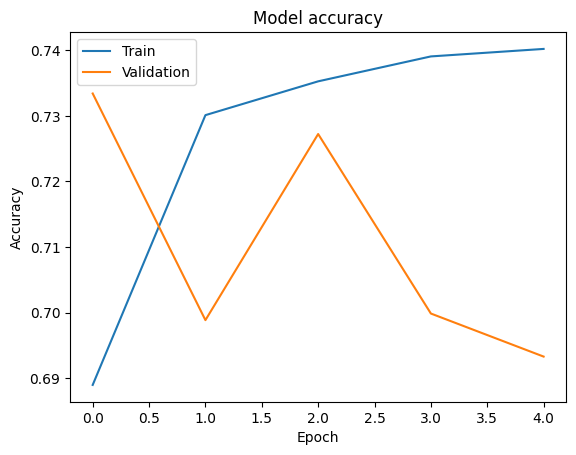

In [26]:

plt.plot(history_cnn.history['accuracy'])
plt.plot(history_cnn.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()


In [28]:
# Save the model
model_cnn.save('my_model.h5')  # creates a HDF5 file 'my_model.h5'


In [30]:
from keras.layers import Dropout
from keras.regularizers import l2
from keras.callbacks import EarlyStopping

model_cnn2 = Sequential(name='CNN_model2')

model_cnn2.add(Conv2D(filters=32, kernel_size=3, input_shape=input_shape, activation='relu', name='Conv_01'))
model_cnn2.add(MaxPooling2D(pool_size=2, name='Pool_01'))
model_cnn2.add(Dropout(0.5, name='Dropout_01'))
model_cnn2.add(Conv2D(filters=32, kernel_size=3, activation='elu', name='Conv_02'))
model_cnn2.add(MaxPooling2D(pool_size=2, name='Pool_02'))
model_cnn2.add(Dropout(0.5, name='Dropout_02'))
model_cnn2.add(Conv2D(filters=32, kernel_size=3, input_shape=input_shape, activation='elu', name='Conv_03'))
model_cnn2.add(MaxPooling2D(pool_size=2, name='Pool_03'))

model_cnn2.add(Flatten(name='Flatten'))

model_cnn2.add(Dense(units=64, activation='relu', name='Dense_01'))
model_cnn2.add(Dense(units=1, activation='relu', name='Dense_02'))

model_cnn2.add(Dense(1, activation='sigmoid', name='Output'))

model_cnn2.summary()
early_stopping = EarlyStopping(monitor='val_loss', patience=10)  # Early stopping
model_cnn2.compile(optimizer=Adam(learning_rate=0.001),
                  loss='binary_crossentropy',
                  metrics=[[AUC(), 'accuracy']])

Model: "CNN_model2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Conv_01 (Conv2D)            (None, 54, 191, 32)       320       
                                                                 
 Pool_01 (MaxPooling2D)      (None, 27, 95, 32)        0         
                                                                 
 Dropout_01 (Dropout)        (None, 27, 95, 32)        0         
                                                                 
 Conv_02 (Conv2D)            (None, 25, 93, 32)        9248      
                                                                 
 Pool_02 (MaxPooling2D)      (None, 12, 46, 32)        0         
                                                                 
 Dropout_02 (Dropout)        (None, 12, 46, 32)        0         
                                                                 
 Conv_03 (Conv2D)            (None, 10, 44, 32)        9

In [31]:
history_cnn2 = model_cnn2.fit(x=train_dataset,
                            epochs=5,
                            validation_data=valid_dataset,
                            batch_size=batch_size,
                            callbacks=[early_stopping],
                            verbose=1)

Epoch 1/5
1680/1680 [==============================] - 5996s 4s/step - loss: 0.6932 - auc_2: 0.4995 - accuracy: 0.5006 - val_loss: 0.6931 - val_auc_2: 0.5000 - val_accuracy: 0.5001
Epoch 2/5
1680/1680 [==============================] - 6039s 4s/step - loss: 0.6932 - auc_2: 0.4992 - accuracy: 0.4994 - val_loss: 0.6931 - val_auc_2: 0.5000 - val_accuracy: 0.5001
Epoch 3/5
1680/1680 [==============================] - 6042s 4s/step - loss: 0.6932 - auc_2: 0.4999 - accuracy: 0.5006 - val_loss: 0.6931 - val_auc_2: 0.5000 - val_accuracy: 0.4999
Epoch 4/5
1680/1680 [==============================] - 6063s 4s/step - loss: 0.6932 - auc_2: 0.5005 - accuracy: 0.4997 - val_loss: 0.6932 - val_auc_2: 0.5000 - val_accuracy: 0.4999
Epoch 5/5
1680/1680 [==============================] - 6045s 4s/step - loss: 0.6932 - auc_2: 0.4989 - accuracy: 0.5002 - val_loss: 0.6931 - val_auc_2: 0.5000 - val_accuracy: 0.5001


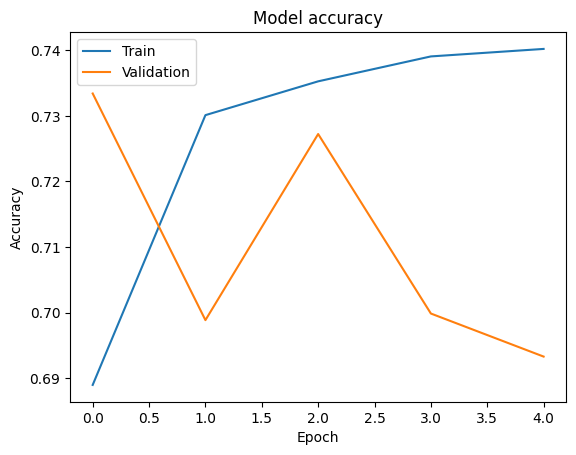

In [32]:
import matplotlib.pyplot as plt

# Plot training & validation accuracy values
plt.plot(history_cnn.history['accuracy'])
plt.plot(history_cnn.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()


In [33]:
# Save the model
model_cnn2.save('my_model.h4')  # creates a HDF5 file 'my_model.h5'


In [20]:
from keras.models import Sequential
from keras.layers import Dense, Conv2D, Flatten, MaxPooling2D

# create model
model = Sequential()

# add model layers
model.add(Conv2D(64, kernel_size=3, activation='relu', input_shape=input_shape))  # Adjust the input_shape parameters as needed
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Conv2D(32, kernel_size=3, activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Flatten())
model.add(Dense(1, activation='sigmoid'))  # Using sigmoid for binary classification

# compile model using binary crossentropy as this is a binary classification problem
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# model summary
model.summary()


Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_2 (Conv2D)           (None, 54, 191, 64)       640       
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 27, 95, 64)       0         
 2D)                                                             
                                                                 
 conv2d_3 (Conv2D)           (None, 25, 93, 32)        18464     
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 12, 46, 32)       0         
 2D)                                                             
                                                                 
 flatten_1 (Flatten)         (None, 17664)             0         
                                                                 
 dense_1 (Dense)             (None, 1)                

In [22]:
%%time
# train model
Hist_simple = model.fit(x= train_dataset, validation_data=valid_dataset, epochs=10, batch_size=batch_size)


Epoch 1/10
1680/1680 [==============================] - 5164s 3s/step - loss: 0.5234 - accuracy: 0.7244 - val_loss: 0.5193 - val_accuracy: 0.7478
Epoch 2/10
1680/1680 [==============================] - 5456s 3s/step - loss: 0.4921 - accuracy: 0.7512 - val_loss: 0.4815 - val_accuracy: 0.7589
Epoch 3/10
1680/1680 [==============================] - 5706s 3s/step - loss: 0.4872 - accuracy: 0.7541 - val_loss: 0.4893 - val_accuracy: 0.7622
Epoch 4/10
1680/1680 [==============================] - 5741s 3s/step - loss: 0.4830 - accuracy: 0.7577 - val_loss: 0.4786 - val_accuracy: 0.7635
Epoch 5/10
1680/1680 [==============================] - 5694s 3s/step - loss: 0.4808 - accuracy: 0.7583 - val_loss: 0.4877 - val_accuracy: 0.7438
Epoch 6/10
1680/1680 [==============================] - 5798s 3s/step - loss: 0.4786 - accuracy: 0.7610 - val_loss: 0.4789 - val_accuracy: 0.7668
Epoch 7/10
1680/1680 [==============================] - 5807s 3s/step - loss: 0.4775 - accuracy: 0.7612 - val_loss: 0.4742 -

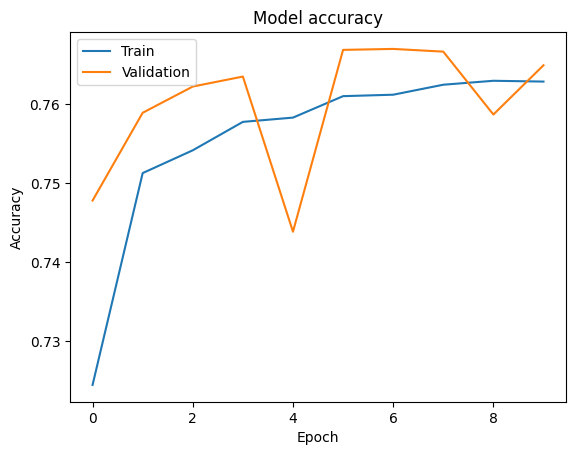

In [24]:
 import matplotlib.pyplot as plt

# Plot training & validation accuracy values
plt.plot(Hist_simple.history['accuracy'])
plt.plot(Hist_simple.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()


In [25]:
from keras.models import Sequential
from keras.layers import Dense, Conv2D, Flatten, MaxPooling2D

# create model
model = Sequential()

# add model layers
model.add(Conv2D(64, kernel_size=3, activation='relu', input_shape=input_shape))  # Adjust the input_shape parameters as needed
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Conv2D(128, kernel_size=3, activation='relu'))  # New Conv2D layer added here
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Conv2D(32, kernel_size=3, activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Flatten())
model.add(Dense(1, activation='sigmoid'))  # Using sigmoid for binary classification

# compile model using binary crossentropy as this is a binary classification problem
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# model summary
model.summary()


Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_4 (Conv2D)           (None, 54, 191, 64)       640       
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 27, 95, 64)       0         
 2D)                                                             
                                                                 
 conv2d_5 (Conv2D)           (None, 25, 93, 128)       73856     
                                                                 
 max_pooling2d_5 (MaxPooling  (None, 12, 46, 128)      0         
 2D)                                                             
                                                                 
 conv2d_6 (Conv2D)           (None, 10, 44, 32)        36896     
                                                                 
 max_pooling2d_6 (MaxPooling  (None, 5, 22, 32)       

In [ ]:
%%time
# train model
Hist_simple = model.fit(x= train_dataset, validation_data=valid_dataset, epochs=5, batch_size=batch_size)


Epoch 1/5
1680/1680 [==============================] - 8852s 5s/step - loss: 0.5128 - accuracy: 0.7321 - val_loss: 0.4836 - val_accuracy: 0.7513
Epoch 2/5
1680/1680 [==============================] - 8529s 5s/step - loss: 0.4835 - accuracy: 0.7563 - val_loss: 0.4827 - val_accuracy: 0.7635
Epoch 3/5
1678/1680 [============================>.] - ETA: 8s - loss: 0.4771 - accuracy: 0.7609 